# Packages

In [123]:
import numpy as np
from osgeo import gdal
import xarray as xr
from scipy.interpolate import NearestNDInterpolator, RegularGridInterpolator
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 10 
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 300

# Function and constants

In [124]:
def xyz_geotiff(img):
    band = img.GetRasterBand(1)
    z = np.flipud(band.ReadAsArray()).T
    width = img.RasterXSize
    height = img.RasterYSize
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    lon = np.linspace(minx,maxx,width)
    lat = np.linspace(miny,maxy,height)
    return lon,lat,z

def transect2dxyz(p0,p1,x,y,z):
    tempinterpolator = RegularGridInterpolator((x,y),z)
    linelength = ((p1[0]-p0[0])**2+(p1[1]-p0[1])**2)**0.5
    spoints = np.arange(0,linelength,np.diff(x)[0])
    xpoints = np.cos(np.arctan2(p1[1]-p0[1],p1[0]-p0[0]))*spoints+p0[0]
    ypoints = np.sin(np.arctan2(p1[1]-p0[1],p1[0]-p0[0]))*spoints+p0[1]
    zpoints = tempinterpolator((xpoints,ypoints))
    return spoints,xpoints,ypoints,zpoints

def get_regulargrid(x,y,z,npoints):
    if type(npoints)==tuple:
        if len(npoints)==2:
            x_grid = np.linspace(np.min(x),np.max(x),npoints[0])
            y_grid = np.linspace(np.min(y),np.max(y),npoints[1])
        else:
            return 'error: npoints as tuple must have len(npoints)==2'
    elif type(npoints)==int:
        x_grid = np.linspace(np.min(x),np.max(x),npoints)
        y_grid = np.linspace(np.min(y),np.max(y),npoints)        
    else:
        return 'error: npoints must be an int or a tuple of length 2'
    finterp2d = NearestNDInterpolator(list(zip(x, y)),z)
    X_grid,Y_grid = np.meshgrid(x_grid,y_grid)
    z_grid = finterp2d(X_grid,Y_grid)
    return x_grid,y_grid,z_grid

# Data

In [125]:
data_geotiff = gdal.Open('mcdunes_AW3D30.tif')
lon_geotiff,lat_geotiff,z_geotiff = xyz_geotiff(data_geotiff)

In [126]:
points_df = pd.read_csv('approxcoords.csv', delimiter='\t')

# Plots

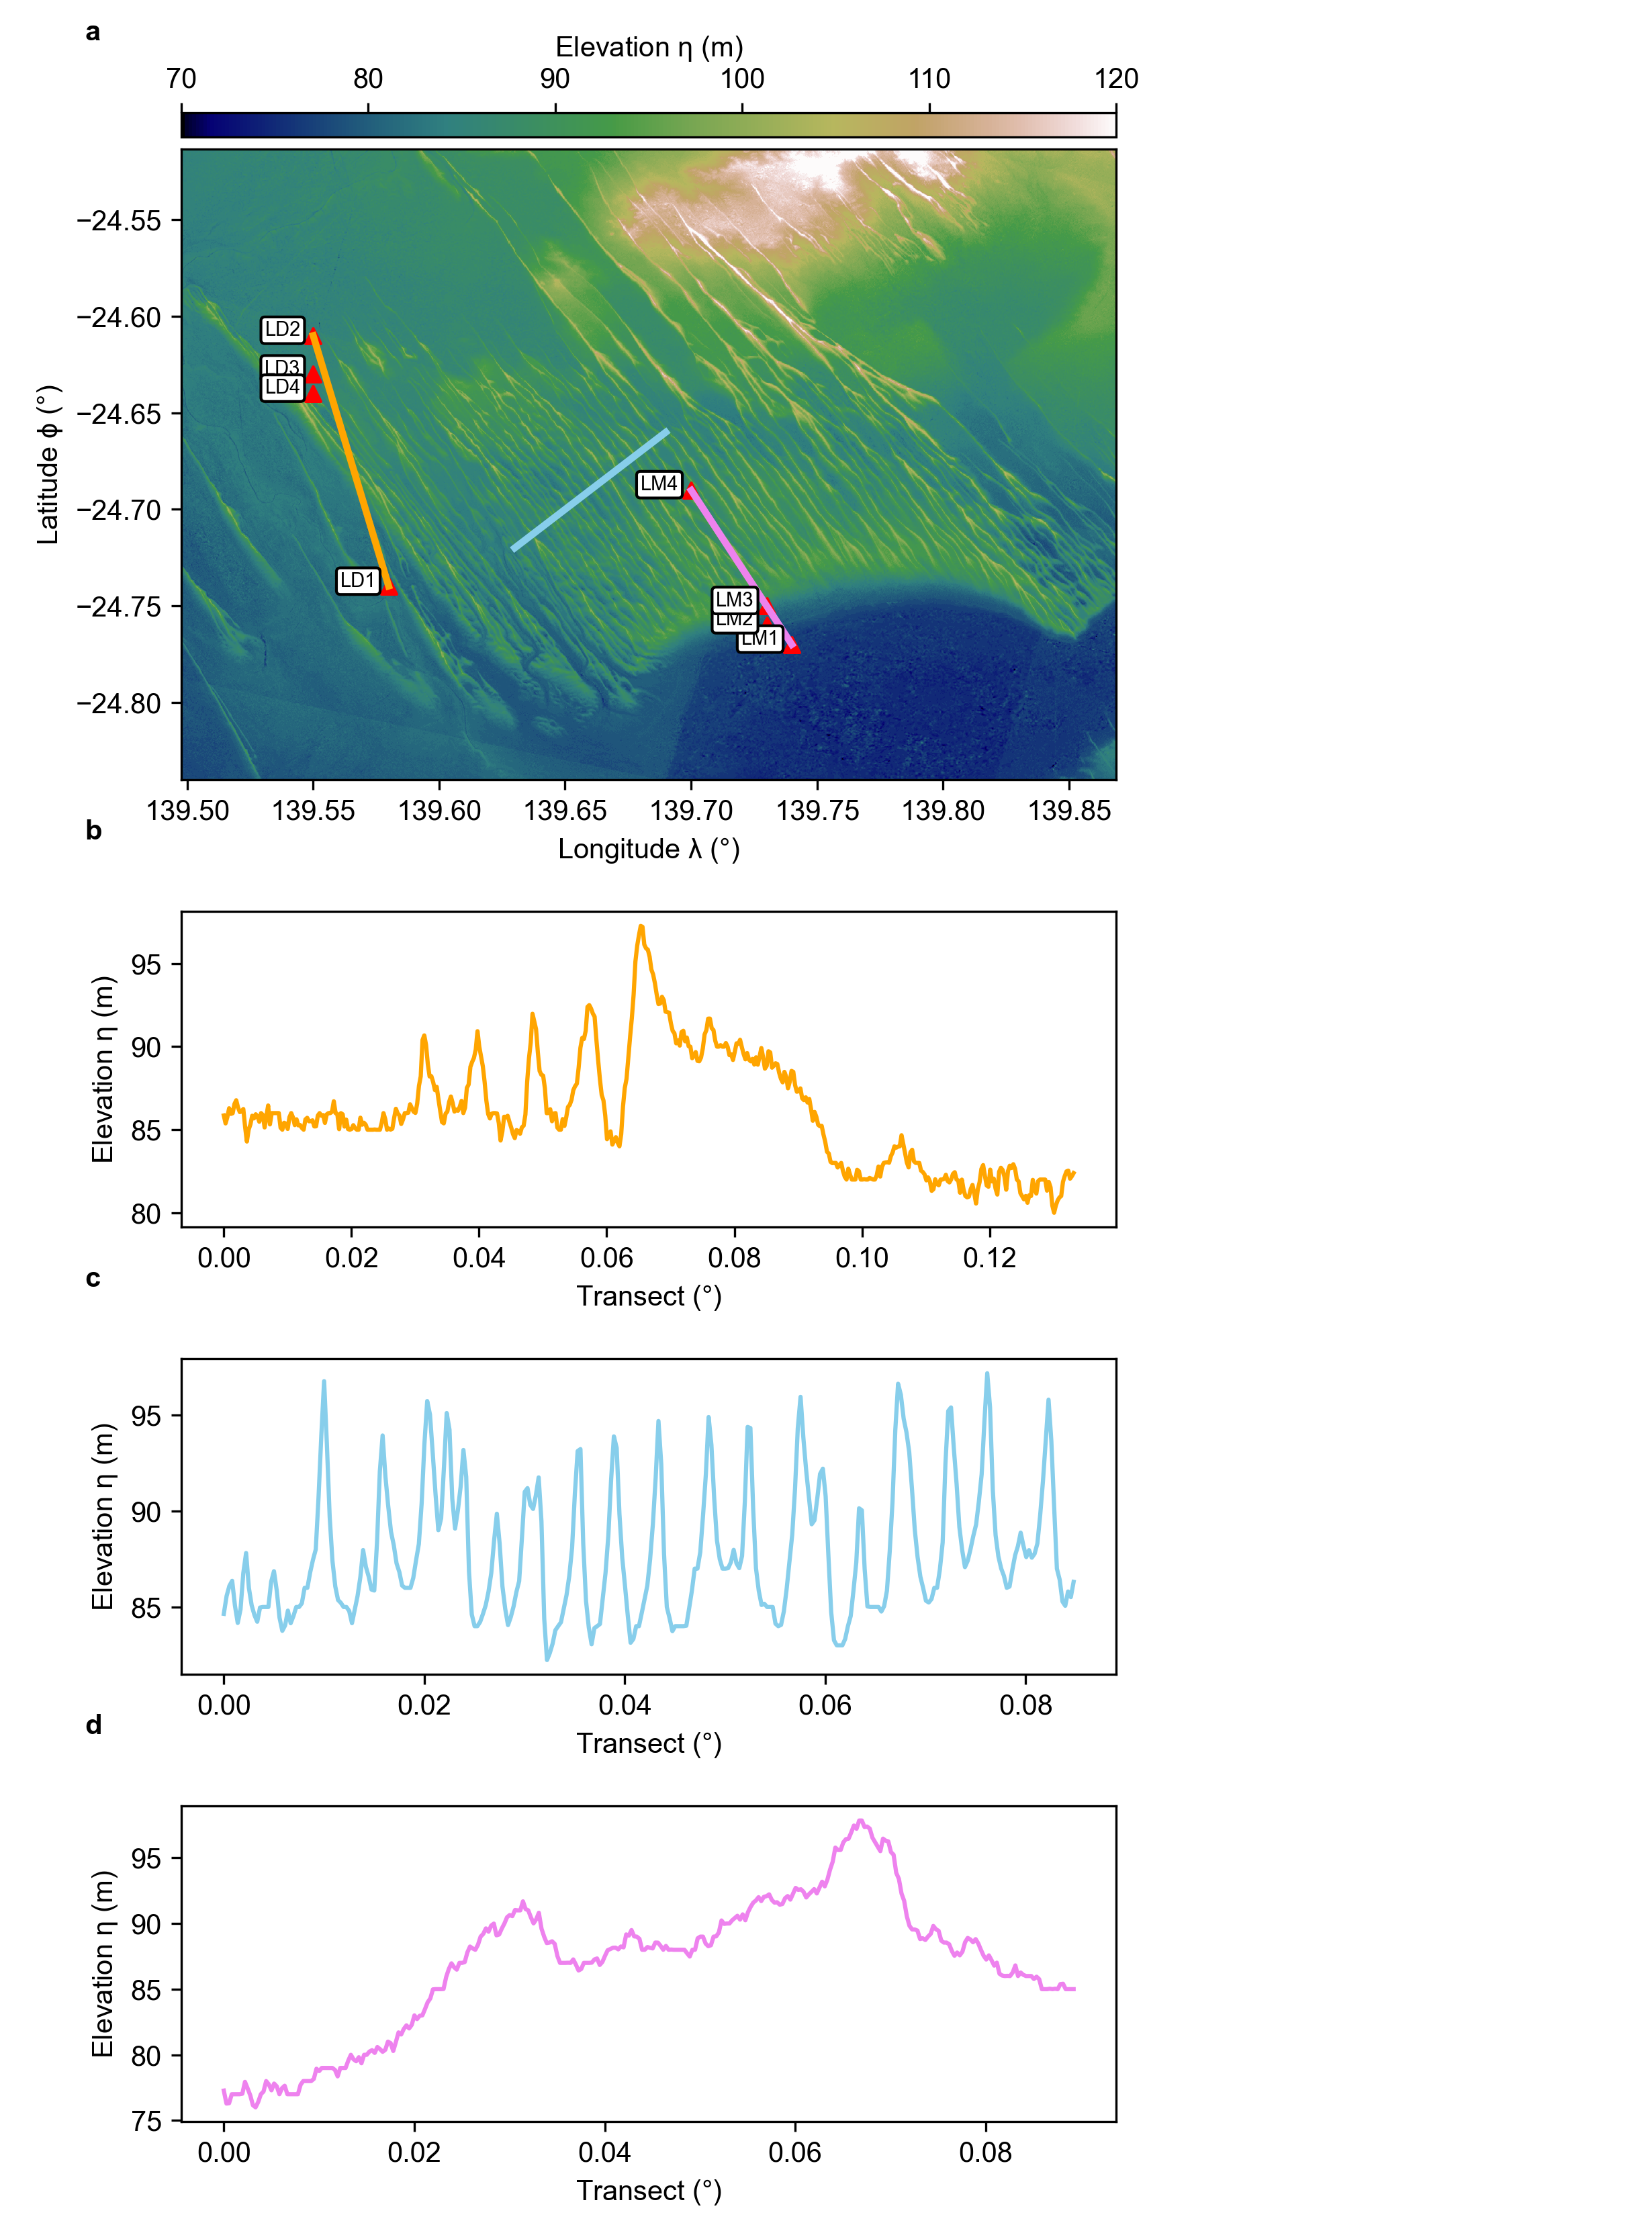

In [133]:
draft = False

lw = 0.5 

hbuf = 0.08
wbuf = 0.08
cbh  = 0.02
pltspan = 0.29
blowbuf = 0.04
labbuf  = 0.06

ax0l, ax0b, ax0w, ax0h = 0.1, 0.52, pltspan * 2 + wbuf - 2 * blowbuf, pltspan *1.8
cb0l, cb0b, cb0w, cb0h = ax0l, ax0b + ax0h + 0.01, ax0w, cbh

ax1l, ax1b, ax1w, ax1h = ax0l, ax0b - pltspan - hbuf, ax0w, ax0h * 0.5
ax2l, ax2b, ax2w, ax2h = ax1l, ax1b - pltspan - hbuf, ax0w, ax0h * 0.5
ax3l, ax3b, ax3w, ax3h = ax2l, ax2b - pltspan - hbuf, ax0w, ax0h * 0.5


etaticks = [70,80,90,100,110,120]

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)

ax00.text(cb0l-labbuf,cb0b+cbh+labbuf,'a',fontsize=10, weight='bold')
ax00.text(ax1l-labbuf,ax1b+ax1h+labbuf,'b',fontsize=10, weight='bold')
ax00.text(ax2l-labbuf,ax2b+ax2h+labbuf,'c',fontsize=10, weight='bold')
ax00.text(ax3l-labbuf,ax3b+ax3h+labbuf,'d',fontsize=10, weight='bold')

if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

p0 = [139.55, -24.61]
p1 = [139.58, -24.74]
spoints,lonpoints,latpoints,zpoints = transect2dxyz(p0,p1, lon_geotiff,lat_geotiff,z_geotiff)

ax0l = 0.1
ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])

pc0 = plt.pcolor(lon_geotiff,lat_geotiff,z_geotiff.T,cmap='gist_earth',vmin=etaticks[0],vmax=etaticks[-1],rasterized=True)
ax0.plot(lonpoints,latpoints,c='orange',linewidth=2.5)

ax0.set_xlabel('Longitude $\\lambda$ ($\\degree$)')
ax0.set_ylabel('Latitude $\\phi$ ($\\degree$)')

data = {
    'Label': ['LD2', 'LD3', 'LD4', 'LD1', 'LM1', 'LM2', 'LM3', 'LM4'],
    'Longitude': [139.55, 139.55, 139.55, 139.58, 139.74, 139.73, 139.73, 139.7],
    'Latitude': [-24.61, -24.63, -24.64, -24.74, -24.77, -24.76, -24.75, -24.69]
}
ax0.scatter(data['Longitude'], data['Latitude'], c='red', s= 30, marker= ('^'), label='CSV Data')
for i, txt in enumerate(data['Label']):
    plt.text(data['Longitude'][i]-0.005, data['Latitude'][i], txt, fontsize=7, ha='right',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

ax1 = fig.add_axes([ax1l,ax1b,ax0w,ax1h])
ax1.plot(spoints,zpoints,c='orange')
ax1.set_xlabel('Transect ($\\degree$)')
ax1.set_ylabel('Elevation $\\eta$ (m)')


ax2 = fig.add_axes([ax2l,ax2b,ax0w,ax2h])

p0 = [139.63,-24.72]
p1 = [139.69,-24.66]
spoints2,lonpoints2,latpoints2,zpoints2 = transect2dxyz(p0,p1, lon_geotiff,lat_geotiff,z_geotiff)
ax0.plot(lonpoints2,latpoints2,c='skyblue',linewidth=2.5)
ax2.plot(spoints2,zpoints2,c='skyblue',)

ax2.set_xlabel('Transect ($\\degree$)')
ax2.set_ylabel('Elevation $\\eta$ (m)')

ax3 = fig.add_axes([ax3l,ax3b,ax0w,ax3h])
p0 = [139.74, -24.77]
p1 = [139.70, -24.69]
spoints3,lonpoints3,latpoints3,zpoints3 = transect2dxyz(p0,p1, lon_geotiff,lat_geotiff,z_geotiff)
ax0.plot(lonpoints3,latpoints3,c='violet',linewidth=2.5)
ax3.plot(spoints3, zpoints3, c='violet',)
ax3.set_xlabel('Transect ($\\degree$)')
ax3.set_ylabel('Elevation $\\eta$ (m)')

cbar0_ax = fig.add_axes([0.1,cb0b, cb0w, cb0h])
cb0 = fig.colorbar(pc0, orientation='horizontal',cax=cbar0_ax, ticks=etaticks)
cbar0_ax.xaxis.set_label_position('top')
cbar0_ax.xaxis.set_ticks_position('top')
cb0.ax.set_xlabel('Elevation $\\eta$ (m)')
cb0.ax.set_xticklabels(etaticks)

fig.set_size_inches(8,6, forward=True)
if draft==False:
    plt.savefig('mcdunes.png',dpi=300,bbox_inches='tight')